In [23]:
from MED.modeling.modeling_utils import retrieve_results_mlflow, retrieve_results_mlflow_ES
import mlflow
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 100 #high resolution
import seaborn as sns
import numpy as np
import pandas as pd
import os
from MED.dataset.CustomFrameDataset import CustomFrameDataset
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import f1_score, accuracy_score, jaccard_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## 1. Ensemble predictions from best video and best kinematics models

In [2]:
#This code ensembles the predictions of Simple CNN trained on video data and kinematics data (separately) using soft voting.

#Set up variables
run_id_video = "705d4490b0a642e1a9c231fdc0eb3bdf"
run_id_kinematics = "f4c962c1b73045d2aa1860a16abbac17"

outs = ['1Out', '2Out', '3Out', '4Out', '5Out']
setting = 'LOSO'

exp_kwargs = {
    'model_name': "SimpleCNN",
    'dataset_type': "frame",
    'save_local': False}

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [3]:
#Retrieve results for video data
video_f1_train, video_f1_test, video_acc_train, video_acc_test, video_jaccard_train, video_jaccard_test, video_cm_train, video_cm_test, \
                test_all_preds_video, test_all_probs_video, test_all_labels_video, test_all_labels_specific_video,test_all_gest_labels_video, test_all_subjects_video = retrieve_results_mlflow(outs=outs,
                                                                                                                   setting=setting,
                                                                                                                   exp_kwargs=exp_kwargs,
                                                                                                                   run_id=run_id_video)

#Retrieve results for kinematics data
kinematics_f1_train, kinematics_f1_test, kinematics_acc_train, kinematics_acc_test, kinematics_jaccard_train, kinematics_jaccard_test, kinematics_cm_train, kinematics_cm_test, \
                test_all_preds_kinematics, test_all_probs_kinematics, test_all_labels_kinematics, test_all_labels_specific_kinematics, test_all_gest_labels_kinematics, test_all_subjects_kinematics = retrieve_results_mlflow(outs=outs,
                                                                                                                   setting=setting,
                                                                                                                   exp_kwargs=exp_kwargs,
                                                                                                                   run_id=run_id_kinematics)

In [20]:
#Check that global error labels (final position of vector) match specific labels
print(len(test_all_labels_kinematics['5Out']), len(test_all_labels_specific_kinematics['5Out']))

for out in outs:
    for i in range(len(test_all_labels_kinematics[out])):
        if test_all_labels_kinematics[out][i][-1] != test_all_labels_specific_kinematics[out][i]:
            print(f"Mismatch at index {i}: {test_all_labels_kinematics[out][i][-1]} != {test_all_labels_specific_kinematics[out][i]}")

        #Check that if global error label is 1 (position -1), at least one specific label is also 1
        if test_all_labels_kinematics[out][i][-1] == 1 and test_all_labels_kinematics[out][i][:-1].sum() == 0:
            print(f"Global error label is 1 but no specific labels are 1 at index {i}")

640 640


In [15]:
def check_subjects_gestures_labels(outs, subjects_video, subjects_kinematics, gestures_video, gestures_kinematics, labels_video, labels_kinematics):
    
    """
    Check if subjects and gestures match between video and kinematics data.
    Raises ValueError if there is a mismatch.
    """

    for out in outs:
        if out not in subjects_video or out not in subjects_kinematics:
            raise ValueError(f"Output {out} not found in subjects data.")
        if out not in gestures_video or out not in gestures_kinematics:
            raise ValueError(f"Output {out} not found in gestures data.")
        
        subjects_video_fold = np.array(subjects_video[out])
        subjects_kinematics_fold = np.array(subjects_kinematics[out])
        gestures_video_fold = np.array(gestures_video[out])
        gestures_kinematics_fold = np.array(gestures_kinematics[out])
        labels_video_fold = np.array(labels_video[out])
        labels_kinematics_fold = np.array(labels_kinematics[out])

        if not np.array_equal(subjects_video_fold, subjects_kinematics_fold):
            raise ValueError(f"Subjects do not match for output {out}: {subjects_video_fold} vs {subjects_kinematics_fold}")
        elif not np.array_equal(gestures_video_fold, gestures_kinematics_fold):
            raise ValueError(f"Gestures do not match for output {out}: {gestures_video_fold} vs {gestures_kinematics_fold}")
        elif not np.array_equal(labels_video_fold, labels_kinematics_fold):
            raise ValueError(f"Labels do not match for output {out}: {labels_video_fold} vs {labels_kinematics_fold}")
        else:
            print(f"Subjects and gestures match for output {out}.")

    

#Check if subjects and gestures match
check_subjects_gestures_labels(outs= outs, 
                             subjects_video=test_all_subjects_video, 
                             subjects_kinematics=test_all_subjects_kinematics, 
                             gestures_video=test_all_gest_labels_video, 
                             gestures_kinematics=test_all_gest_labels_kinematics,
                            labels_video=test_all_labels_specific_video,
                            labels_kinematics=test_all_labels_specific_kinematics)

Subjects and gestures match for output 1Out.
Subjects and gestures match for output 2Out.
Subjects and gestures match for output 3Out.
Subjects and gestures match for output 4Out.
Subjects and gestures match for output 5Out.


Shape of concatenated predictions: (4252,)
Shape of concatenated labels: (4252,)


,Accuracy,F1 Score,Jaccard Index
Ensemble,0.675917,0.716811,0.558616


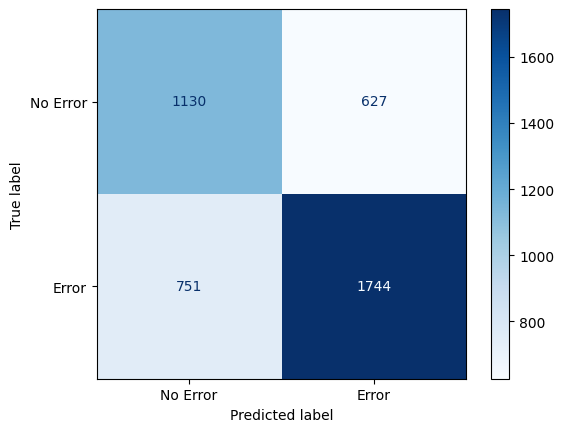

In [16]:
#Ensemble predictions per fold (out) using soft voting
ensemble_preds = {}
video_preds = {}
kinematics_preds = {}
true_labels = {}
ensemble_cm = np.empty((2,2))
results_df = pd.DataFrame(columns = ['Accuracy', 'F1 Score', 'Jaccard Index'])

for out in outs:
    probs_video = np.array(test_all_probs_video[out])
    probs_kinematics = np.array(test_all_probs_kinematics[out])
    
    true_labels[out] = np.array(test_all_labels_specific_video[out]) 
    video_preds[out] = (probs_video >= 0.5).astype(int)  
    kinematics_preds[out] = (probs_kinematics >= 0.5).astype(int)
    
    #Soft voting of binary classification. Probs represent the probabilities of the positive class.
    ensemble_probs = (probs_video + probs_kinematics) / 2
    ensemble_preds[out] = (ensemble_probs >= 0.5).astype(int)

#Get single np.array for preds and labels
preds_concat = np.concatenate(list(ensemble_preds.values()))
labels_concat = np.concatenate(list(true_labels.values()))

print(f"Shape of concatenated predictions: {preds_concat.shape}")
print(f"Shape of concatenated labels: {labels_concat.shape}")

#Calculate metrics
ensemble_f1 = f1_score(labels_concat, preds_concat, average='binary')
ensemble_acc = accuracy_score(labels_concat, preds_concat)
ensemble_jaccard = jaccard_score(labels_concat, preds_concat, average='binary')

#Calculate confusion matrix
ensemble_cm = confusion_matrix(labels_concat, preds_concat)
results_df.loc['Ensemble'] = [ensemble_acc, ensemble_f1, ensemble_jaccard]

#Print results
display(results_df)

#Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=['No Error', 'Error']).plot(cmap='Blues')

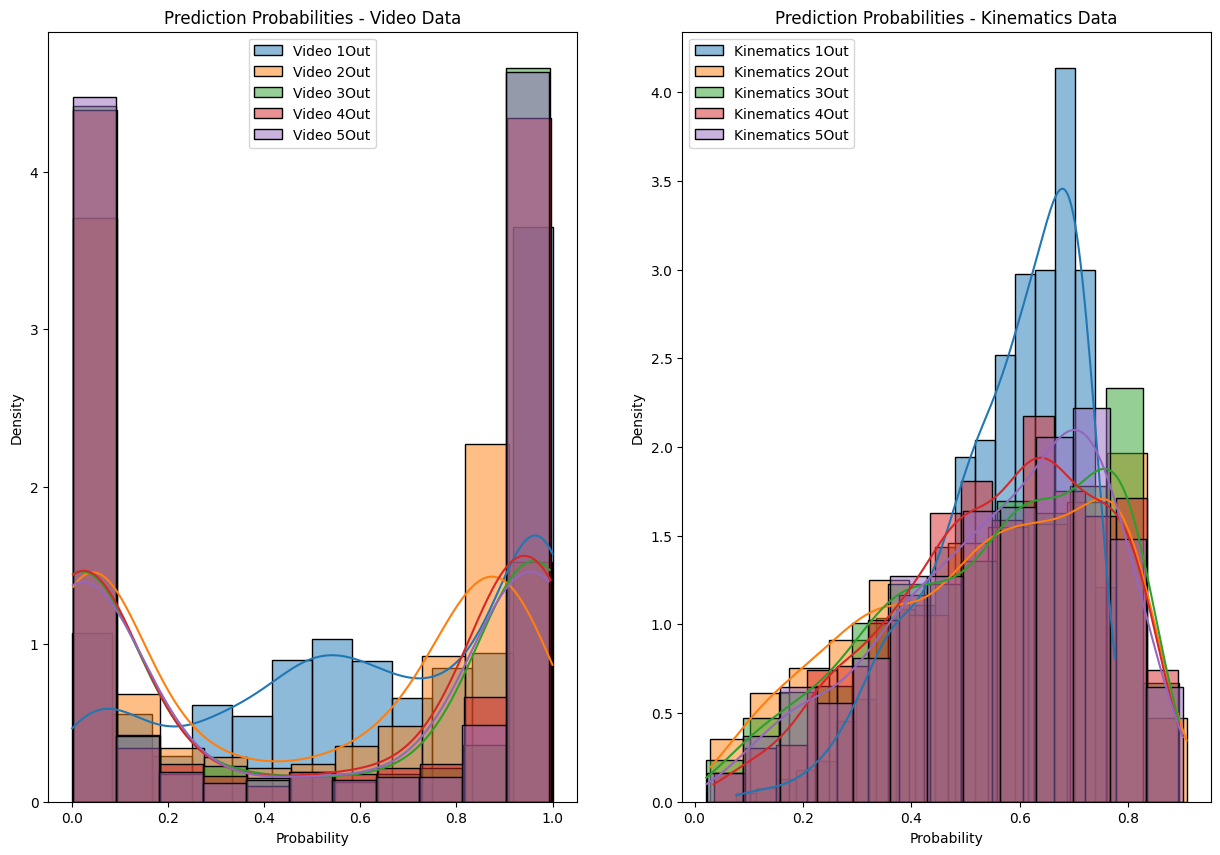

In [ ]:
#Plot distribution of prediction probabilities per folds
#2 columns (video, kinematics) and 5 columns (outs)
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

for out in outs:
    sns.histplot(test_all_probs_video[out], label=f'Video {out}', kde=True, stat='density', fill=True)
plt.title('Prediction Probabilities - Video Data')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
for out in outs:
    sns.histplot(test_all_probs_kinematics[out], label=f'Kinematics {out}', kde=True, stat='density', fill=True)
plt.title('Prediction Probabilities - Kinematics Data')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

In [18]:
#Compute percentage of overlap between video and kinematics predictions per fold
overlaps = {}

for out in outs:
    video_preds_fold = np.array(video_preds[out])
    kinematics_preds_fold = np.array(kinematics_preds[out])
    true_labels_fold = np.array(true_labels[out])
    
    count_total = 0
    count_overlap = 0
    correct_inside_overlap = 0
    for i in range(len(video_preds_fold)):
        if video_preds_fold[i] == kinematics_preds_fold[i]:
            count_overlap += 1
            if video_preds_fold[i] == true_labels_fold[i]:
                correct_inside_overlap += 1

        count_total += 1

    overlap_percentage = (count_overlap / count_total) * 100
    correct_inside_overlap = (correct_inside_overlap / count_overlap) if count_overlap > 0 else 0
    print(f"Overlap for {out}: {overlap_percentage:.2f}% (Correct inside overlap: {correct_inside_overlap:.2f})")
    overlaps[out] = overlap_percentage

    

Overlap for 1Out: 63.36% (Correct inside overlap: 0.78)
Overlap for 2Out: 67.78% (Correct inside overlap: 0.66)
Overlap for 3Out: 66.33% (Correct inside overlap: 0.69)
Overlap for 4Out: 63.68% (Correct inside overlap: 0.77)
Overlap for 5Out: 62.19% (Correct inside overlap: 0.78)


## 2. Visualize best multimodal model probabilities distribution

In [8]:
# 2. Visualize best multimodal model probabilities distribution
run_id = "fc159a057aba46ce81547822fdb282b0"

outs = ['1Out', '2Out', '3Out', '4Out', '5Out']
setting = 'LOSO'

exp_kwargs = {
    'model_name': "COG",
    'dataset_type': "frame",
    'save_local': False,
    "compute_from_str": False}

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

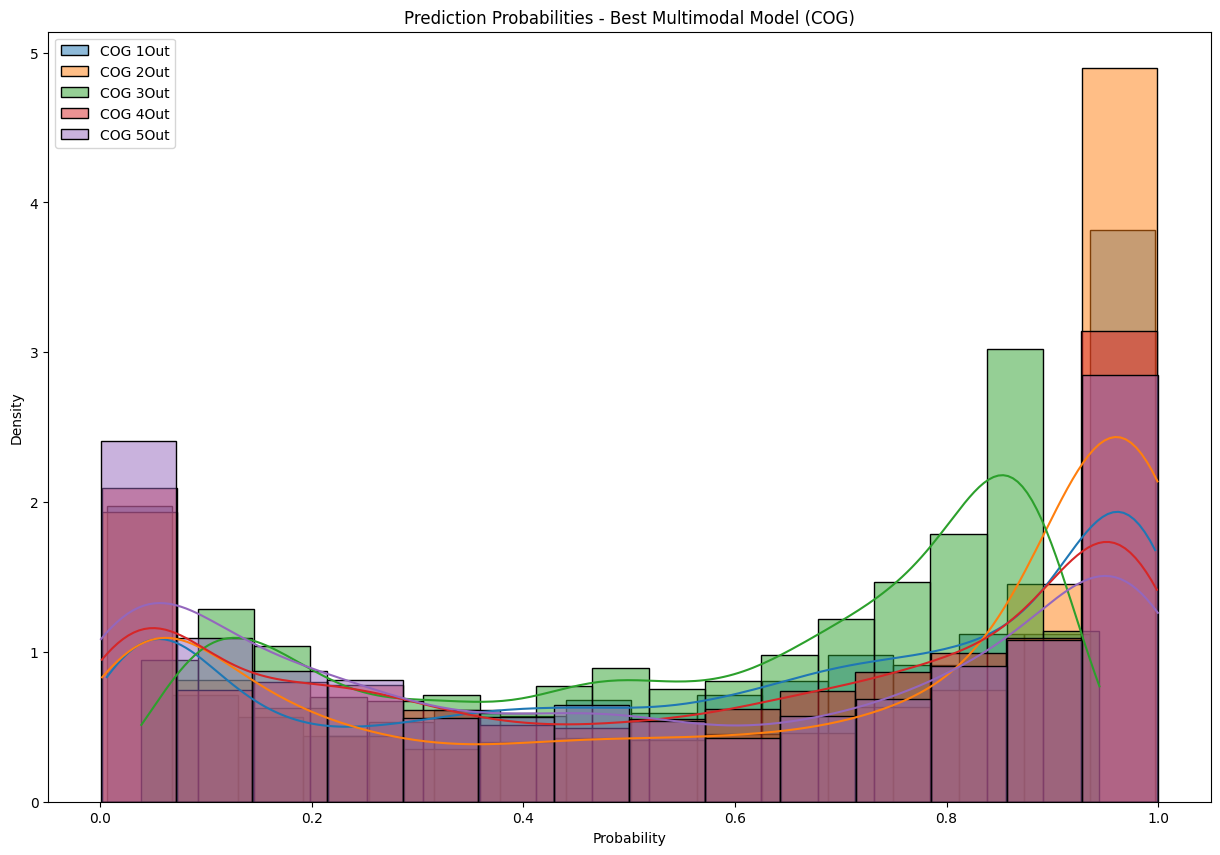

In [9]:
#Retrieve results for best multimodal model
cog_f1_train, cog_f1_test, cog_acc_train, cog_acc_test, cog_jaccard_train, cog_jaccard_test, cog_cm_train, cog_cm_test, \
                test_all_preds_cog, test_all_probs_cog, test_all_labels_cog, test_all_labels_specific_cog, test_all_gest_labels_cog, test_all_subjects_cog = retrieve_results_mlflow(outs=outs,
                                                                                                                   setting=setting,
                                                                                                                   exp_kwargs=exp_kwargs,
                                                                                                                   run_id=run_id)

#Plot distribution of prediction probabilities for best multimodal model
plt.figure(figsize=(15, 10))
for out in outs:
    sns.histplot(test_all_probs_cog[out], label=f'COG {out}', kde=True, stat='density', fill=True)
plt.title('Prediction Probabilities - Best Multimodal Model (COG)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

## 3. Ensemble binary and multimodal predictions.

In [24]:
#Ensemble binary and multimodal predictions.

#a. Retrieve best binary model (COG-multimodal) and get its test predictions and labels.
# Retrieve also predictions from multi-class model (COG-multimodal).

#b. - If a sample is predicted as non-error, then it is non-error in the ensemble.
#    - If a sample is predicted as error, then we take the prediction from the multi-class model.

#Set up variables
run_id_binary = "fc159a057aba46ce81547822fdb282b0"
run_id_multiclass = "da8dcc4eef1c4f11832ac84a66c7f480"

outs = ['1Out', '2Out', '3Out', '4Out', '5Out']
setting = 'LOSO'

exp_kwargs_binary = {
    'error_type': 'global',
    'model_name': "COG",
    'dataset_type': "frame",
    'save_local': False,
    "compute_from_str": False}

exp_kwargs_multiclass = {
    'error_type': 'all_errors',
    'model_name': "COG",
    'dataset_type': "frame",
    'save_local': False,
    "compute_from_str": True}

mlflow.set_tracking_uri(uri="http://localhost:8080")

In [25]:
#Retrieve results for best binary model
binary_f1_train, binary_f1_test, binary_acc_train, binary_acc_test, binary_jaccard_train, binary_jaccard_test, binary_cm_train, binary_cm_test, \
                test_all_preds_binary, test_all_probs_binary, test_all_labels_binary, test_all_labels_specific_binary, test_all_gest_labels_binary, test_all_subjects_binary = retrieve_results_mlflow(outs=outs,
                                                                                                                   setting=setting,
                                                                                                                   exp_kwargs=exp_kwargs_binary,   
                                                                                                                    run_id=run_id_binary)


#Retrieve results for best multi-class model:
multiclass_f1_train, multiclass_f1_train_binary, multiclass_f1_test, multiclass_f1_test_binary, multiclass_acc_train, multiclass_acc_train_binary, multiclass_acc_test, multiclass_acc_test_binary, \
multiclass_jaccard_train, multiclass_jaccard_train_binary, multiclass_jaccard_test, multiclass_jaccard_test_binary, \
multiclass_cm_train, multiclass_cm_train_binary, multiclass_cm_test, multiclass_cm_test_binary, test_all_preds_multiclass,\
test_all_preds_multiclass_binary, test_all_probs_multiclass, test_all_labels_multiclass, test_all_labels_multiclass_binary, test_all_gest_labels_multiclass, test_all_subjects_multiclass = \
                                                                                                                    retrieve_results_mlflow_ES(outs=outs,
                                                                                                                   setting=setting,
                                                                                                                   exp_kwargs=exp_kwargs_multiclass,   
                                                                                                                    run_id=run_id_multiclass)


In [ ]:
#Compute ensemble predictions:
# - If a sample is predicted as non-error, then it is non-error in the ensemble.
#   - If a sample is predicted as error, then we take the prediction from the multi-class model.

ensemble_preds_binary = {}
ensemble_preds_multiclass = {}
true_labels_binary = {}
true_labels_multiclass = {}
samples = []  
f1_binary, acc_binary, jaccard_binary, f1_multiclass, acc_multiclass, jaccard_multiclass = [], [], [], [], [], []
ensemble_cm_binary = np.zeros((2,2))
ensemble_cm_multiclass = np.zeros((6, 6))
results_df_ensemble = pd.DataFrame(columns = ['F1 (binary)', 'Accuracy (binary)', 'Jaccard Index (binary)', 'F1 (multiclass)', 'Accuracy (multiclass)', 'Jaccard Index (multiclass)'])

#1. Ensemble
for out in outs:
    
    binary_preds_fold = np.array(test_all_preds_binary[out])
    multiclass_preds_fold = np.array(test_all_preds_multiclass[out])
    true_labels_binary[out] = np.array(test_all_labels_specific_binary[out]) 
    true_labels_multiclass[out] = np.array(test_all_labels_multiclass[out]) 

    #Pre. i) As ND error was dropped (but considered in binary class model), we need to load a file (if present) that tells us which positions from which subject to drop.
    fold_data_path = f"data/LOSO/5Hz/" + out + '/'

    mask_position_ND = None
    for file in os.listdir(fold_data_path):
        if file.startswith('mask_position_ND_') and file.endswith('.pth'):
            subject = file.split('.')[0].replace('mask_position_ND_', '')  #Extract subject from filename
            mask_position_ND = torch.load(os.path.join(fold_data_path, file)) # 
            print(f"Loaded mask for Needle Drop positions from {file}")
            break
    
    #Pre ii) If mask_position_ND exists, find indices of the subject.
    test_all_subjects_binary_out = np.array(test_all_subjects_binary[out])
    if mask_position_ND is not None:
        subject_indices_ND = np.where(test_all_subjects_binary_out == subject)[0]
        print(f"Found {len(subject_indices_ND)} indices for subject {subject} with Needle Drop positions.")
        
        #Pre iii) Expand mask_position_ND to match
        expanded_mask_position_ND = np.zeros_like(binary_preds_fold, dtype=bool)
        expanded_mask_position_ND[subject_indices_ND] = mask_position_ND
        print(f"Expanded mask for Needle Drop positions to match predictions.")

        #Pre iv) If mask_position_ND exists, remove those positions from binary and multi-class predictions.
        print(binary_preds_fold.shape)
        binary_preds_fold = binary_preds_fold[~expanded_mask_position_ND]
        true_labels_binary[out] = true_labels_binary[out][~expanded_mask_position_ND]
        print(binary_preds_fold.shape)
        
    #Ensemble predictions
    #i. Retrieve positions where binary model predicts error (1)
    error_indices = np.where(binary_preds_fold == 1)[0]

    #ii. Retrieve multi-class predictions at those positions
    multiclass_at_error_indices = multiclass_preds_fold[error_indices]

    #iii. In all other indices, set prediction to non-error (0)
    ensemble_preds_multiclass[out] = np.zeros_like(multiclass_preds_fold)
    ensemble_preds_multiclass[out][error_indices] = multiclass_at_error_indices

    #iv. For binary ensemble predictions, set to 1 where multi-class prediction is not 0
    ensemble_preds_binary[out] = (ensemble_preds_multiclass[out] != 0).astype(int)

    #v. Compute metrics for binary ensemble
    f1_b = f1_score(true_labels_binary[out], ensemble_preds_binary[out], average='binary')
    acc_b = accuracy_score(true_labels_binary[out], ensemble_preds_binary[out])
    jaccard_b = jaccard_score(true_labels_binary[out], ensemble_preds_binary[out], average='binary')
    f1_binary.append(f1_b)
    acc_binary.append(acc_b)
    jaccard_binary.append(jaccard_b)

    #vi. Compute metrics for multi-class ensemble
    f1_m = f1_score(true_labels_multiclass[out], ensemble_preds_multiclass[out], average='weighted')
    acc_m = accuracy_score(true_labels_multiclass[out], ensemble_preds_multiclass[out])
    jaccard_m = jaccard_score(true_labels_multiclass[out], ensemble_preds_multiclass[out], average='weighted')
    f1_multiclass.append(f1_m)
    acc_multiclass.append(acc_m)
    jaccard_multiclass.append(jaccard_m)

    #vii. Compute confusion matrices
    cm_b = confusion_matrix(true_labels_binary[out], ensemble_preds_binary[out])
    cm_m = confusion_matrix(true_labels_multiclass[out], ensemble_preds_multiclass[out])
    ensemble_cm_binary += cm_b
    ensemble_cm_multiclass += cm_m

    samples.append(len(test_all_labels_specific_binary[out]))  

#2. Aggregate metrics in df
results_df_ensemble.loc['Ensemble', 'Accuracy (binary)'] = f"{np.average(acc_binary, weights=samples):.3f} ± {np.average((acc_binary - np.average(acc_binary, weights=samples))**2, weights=samples)**0.5:.3f}"
results_df_ensemble.loc['Ensemble', 'F1 (binary)'] = f"{np.average(f1_binary, weights=samples):.3f} ± {np.average((f1_binary - np.average(f1_binary, weights=samples))**2, weights=samples)**0.5:.3f}"
results_df_ensemble.loc['Ensemble', 'Jaccard Index (binary)'] = f"{np.average(jaccard_binary, weights=samples):.3f} ± {np.average((jaccard_binary - np.average(jaccard_binary, weights=samples))**2, weights=samples)**0.5:.3f}"
results_df_ensemble.loc['Ensemble', 'Accuracy (multiclass)'] = f"{np.average(acc_multiclass, weights=samples):.3f} ± {np.average((acc_multiclass - np.average(acc_multiclass, weights=samples))**2, weights=samples)**0.5:.3f}"
results_df_ensemble.loc['Ensemble', 'F1 (multiclass)'] = f"{np.average(f1_multiclass, weights=samples):.3f} ± {np.average((f1_multiclass - np.average(f1_multiclass, weights=samples))**2, weights=samples)**0.5:.3f}"
results_df_ensemble.loc['Ensemble', 'Jaccard Index (multiclass)'] = f"{np.average(jaccard_multiclass, weights=samples):.3f} ± {np.average((jaccard_multiclass - np.average(jaccard_multiclass, weights=samples))**2, weights=samples)**0.5:.3f}"

display(results_df_ensemble)

Loaded mask for Needle Drop positions from mask_position_ND_Needle_Passing_D001.pth
Found 768 indices for subject Needle_Passing_D001 with Needle Drop positions.
Expanded mask for Needle Drop positions to match predictions.
(8332,)
(8303,)
Loaded mask for Needle Drop positions from mask_position_ND_Suturing_H003.pth
Found 525 indices for subject Suturing_H003 with Needle Drop positions.
Expanded mask for Needle Drop positions to match predictions.
(7066,)
(7040,)


,F1 (binary),Accuracy (binary),Jaccard Index (binary),F1 (multiclass),Accuracy (multiclass),Jaccard Index (multiclass)
Ensemble,0.643 ± 0.055,0.664 ± 0.032,0.477 ± 0.061,0.562 ± 0.047,0.585 ± 0.042,0.408 ± 0.050


<Figure size 1500x1500 with 0 Axes>

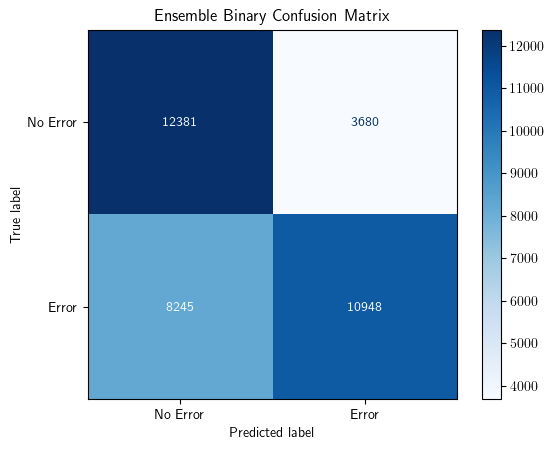

<Figure size 1500x1500 with 0 Axes>

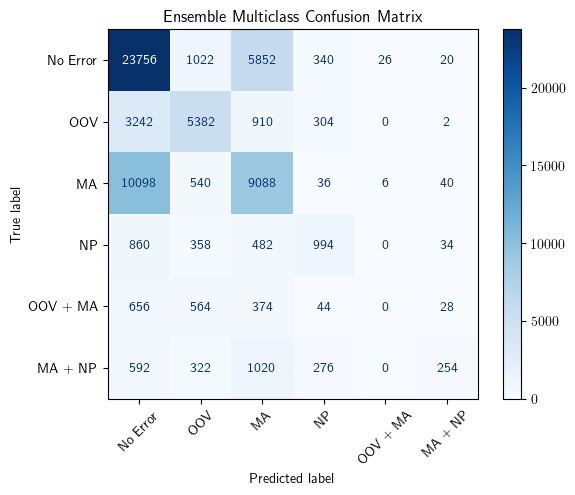

In [33]:
#Plot confusion matrices
plt.figure(figsize=(15, 15))
ConfusionMatrixDisplay(confusion_matrix=ensemble_cm_binary.astype(np.float64), display_labels=['No Error', 'Error']).plot(cmap='Blues', values_format='.0f')
plt.title('Ensemble Binary Confusion Matrix')
plt.show()

plt.figure(figsize=(15, 15))
ConfusionMatrixDisplay(confusion_matrix=ensemble_cm_multiclass.astype(np.float64), display_labels=['No Error', 'OOV', 'MA', 'NP', 'OOV + MA', 'MA + NP']).plot(cmap='Blues', values_format='.0f')
plt.title('Ensemble Multiclass Confusion Matrix')  
plt.xticks(rotation=45)
plt.show()

In [ ]:


for out in outs:

    best_f1 = 0.0
    best_loss = float('inf')    
    save_best = False

    #a. Load training and testing data
    print(f"Loading data for {setting} with trial {out}...")
    fold_data_path = f"data/LOSO/5Hz/" + out + '/'
    video_data_path = f"../Chain-of-Gesture/dataset/setting_f1/LOSO/All/{out}"
        
    #b. Retrieve dataloaders
    test_dataset = CustomFrameDataset(fold_data_path=fold_data_path,
                                        video_data_path=video_data_path,
                                        csv_filename='test.csv',
                                        delete_ND=True)
    
    test_dataloader = DataLoader(test_dataset,
                                batch_size=1, 
                                shuffle=False,
                                generator=torch.Generator().manual_seed(42))  
    
    for i, batch in enumerate(test_dataloader):
        
        images, kinematics, g_labels, e_labels, subject, skill_level = batch

Loading data for LOSO with trial 1Out...
torch.Size([768, 2048])
Subject: Needle_Passing_D001  - Deleting Needle Drop positions from features and labels.
torch.Size([739, 2048])
Loading data for LOSO with trial 2Out...
Loading data for LOSO with trial 3Out...
torch.Size([525, 2048])
Subject: Suturing_H003  - Deleting Needle Drop positions from features and labels.
torch.Size([499, 2048])
Loading data for LOSO with trial 4Out...
Loading data for LOSO with trial 5Out...
